Epoch 1/150


C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ul_input', 'dl_input', 'temporal_input', 'protocol_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - dl_flow_output_loss: 0.9090 - loss: 3.4059 - protocol_output_loss: 0.8047 - temporal_output_loss: 0.7623 - ul_flow_output_loss: 0.9299 - val_dl_flow_output_loss: 0.1127 - val_loss: 0.7177 - val_protocol_output_loss: 0.3728 - val_temporal_output_loss: 0.0648 - val_ul_flow_output_loss: 0.1710 - learning_rate: 0.0010
Epoch 2/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - dl_flow_output_loss: 0.2092 - loss: 0.6462 - protocol_output_loss: 0.1347 - temporal_output_loss: 0.1152 - ul_flow_output_loss: 0.1871 - val_dl_flow_output_loss: 0.0380 - val_loss: 0.6797 - val_protocol_output_loss: 0.5409 - val_temporal_output_loss: 0.0390 - val_ul_flow_output_loss: 0.0625 - learning_rate: 0.0010
Epoch 3/150
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - dl_flow_output_loss: 0.1227 - loss: 0.4254 - protocol_output_loss: 0.0913 - temporal_output_loss: 0.0909 - ul_flow_output_loss: 0.1205 - val_dl_flow_output_loss: 0.0213 - val_loss: 0.5194 - val_protocol_output_l

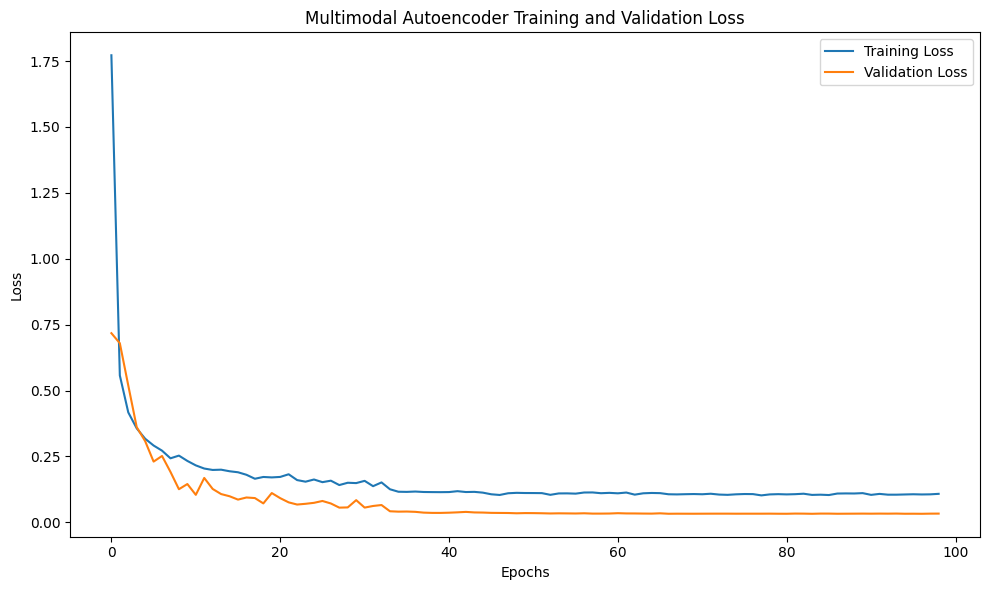

706/706 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Classification Performance Metrics:
Accuracy: 0.8212
Precision (Weighted): 0.8218
Recall (Weighted): 0.8212
F1 Score (Weighted): 0.8210

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       326
           1       0.75      0.80      0.78       285
           2       0.80      0.83      0.81       350
           3       0.86      0.90      0.88       328
           4       0.84      0.79      0.81       301
           5       0.82      0.83      0.82       328
           6       0.77      0.83      0.80       313
           7       0.88      0.88      0.88       324
           8       0.85      0.80      0.82       317
           9       0.78      0.78      0.78       336
          10       0.77      0.73      0.75       284
          11       0.83      0.82      0.82       344
          12       0.85      0.78      0.81       329
          13       0.82      0.81      0.

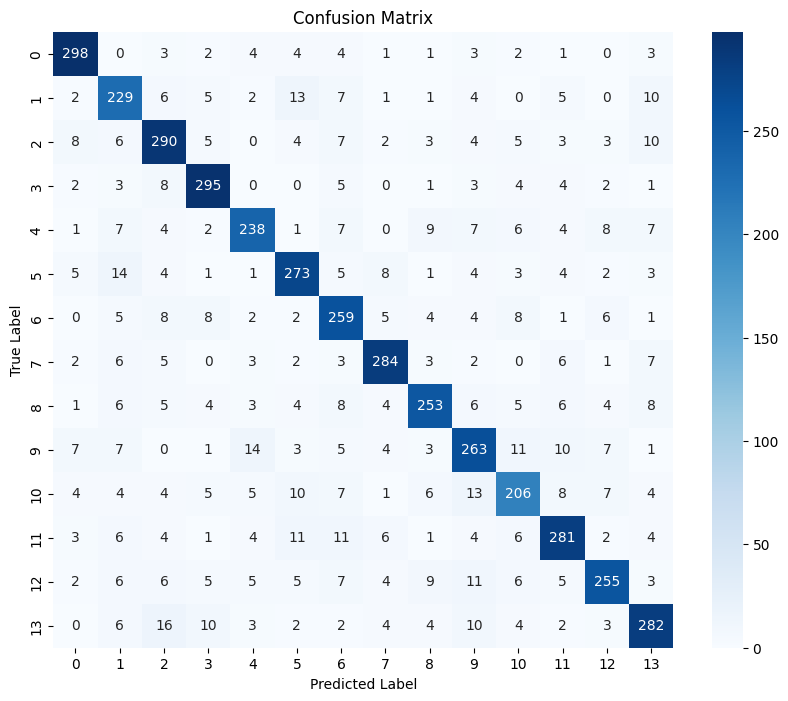

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)

def preprocess_features(data):
    # Separate features
    ul_flow_features = ['ul_total_num_pkts', 'ul_total_num_bytes', 'ul_min_pkt_size', 
                       'ul_max_pkt_size', 'ul_mean_pkt_size', 'ul_std_pkt_size']
    
    dl_flow_features = ['dl_total_num_pkts', 'dl_total_num_bytes', 'dl_min_pkt_size', 
                       'dl_max_pkt_size', 'dl_mean_pkt_size', 'dl_std_pkt_size']
    
    temporal_features = ['ul_min_iat', 'ul_max_iat', 'ul_mean_iat', 'ul_std_iat', 'ul_dur',
                        'dl_min_iat', 'dl_max_iat', 'dl_mean_iat', 'dl_std_iat', 'dl_dur']
    
    # Feature engineering
    data['ul_byte_pkt_ratio'] = data['ul_total_num_bytes'] / (data['ul_total_num_pkts'] + 1e-6)
    data['dl_byte_pkt_ratio'] = data['dl_total_num_bytes'] / (data['dl_total_num_pkts'] + 1e-6)
    data['total_duration'] = data['ul_dur'] + data['dl_dur']
    data['pkt_ratio'] = data['ul_total_num_pkts'] / (data['dl_total_num_pkts'] + 1e-6)
    
    # Log transform temporal features
    for col in temporal_features:
        data[col] = np.log1p(data[col])
    
    # IP address processing
    data['ip_A'] = data['ip_A'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    data['ip_B'] = data['ip_B'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    
    # Protocol one-hot encoding
    protocol_encoder = OneHotEncoder(sparse_output=False)
    protocol_encoded = protocol_encoder.fit_transform(data[['protocal']])
    protocol_df = pd.DataFrame(protocol_encoded, 
                             columns=[f'protocol_{i}' for i in range(protocol_encoded.shape[1])])
    
    # Combine features
    feature_sets = {
        'ul_flow': ul_flow_features + ['ul_byte_pkt_ratio'],
        'dl_flow': dl_flow_features + ['dl_byte_pkt_ratio'],
        'temporal': temporal_features + ['total_duration'],
        'protocol': ['ip_A', 'ip_B', 'port_A', 'port_B'] + [f'protocol_{i}' for i in range(protocol_encoded.shape[1])]
    }
    
    # Scale features
    scalers = {}
    scaled_features = {}
    
    for name, feature_list in feature_sets.items():
        if name == 'protocol':
            features = pd.concat([data[['ip_A', 'ip_B', 'port_A', 'port_B']], protocol_df], axis=1)
        else:
            features = data[feature_list]
        
        scalers[name] = StandardScaler()
        scaled_features[name] = scalers[name].fit_transform(features)
    
    return scaled_features, scalers, protocol_encoder

def create_enhanced_autoencoder(input_sizes):
    inputs = {
        'ul_flow': Input(shape=(input_sizes['ul_flow'],), name="ul_input"),
        'dl_flow': Input(shape=(input_sizes['dl_flow'],), name="dl_input"),
        'temporal': Input(shape=(input_sizes['temporal'],), name="temporal_input"),
        'protocol': Input(shape=(input_sizes['protocol'],), name="protocol_input")
    }
    
    encoded = {}
    for name, input_layer in inputs.items():
        x = Dense(256, activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        encoded[name] = Dropout(0.3)(x)
    
    combined = Concatenate()(list(encoded.values()))
    
    latent = Dense(256, activation='relu', name="latent_space")(combined)
    latent = BatchNormalization()(latent)
    latent = Dropout(0.4)(latent)
    
    decoded = {}
    for name, input_size in input_sizes.items():
        x = Dense(128, activation='relu')(latent)
        x = BatchNormalization()(x)
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization()(x)
        decoded[name] = Dense(input_size, activation='linear', name=f"{name}_output")(x)
    
    autoencoder = Model(
        inputs=list(inputs.values()),
        outputs=list(decoded.values())
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    losses = {f"{name}_output": 'mean_squared_error' for name in input_sizes.keys()}
    autoencoder.compile(optimizer=optimizer, loss=losses)
    
    return autoencoder

def train_model(data_path):
    data = pd.read_csv(data_path)
    labels = data['app']
    
    scaled_features, scalers, protocol_encoder = preprocess_features(data)
    input_sizes = {name: features.shape[1] for name, features in scaled_features.items()}
    
    autoencoder = create_enhanced_autoencoder(input_sizes)
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]
    
    history = autoencoder.fit(
        list(scaled_features.values()),
        list(scaled_features.values()),
        epochs=150,
        batch_size=64,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )

     # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Multimodal Autoencoder Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()
    
    encoder = Model(
        inputs=autoencoder.inputs,
        outputs=autoencoder.get_layer('latent_space').output
    )
    
    latent_features = encoder.predict(list(scaled_features.values()))
    
    X_train, X_test, y_train, y_test = train_test_split(
        latent_features, labels, test_size=0.2, random_state=42
    )
    
    rf_classifier = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    rf_classifier.fit(X_train, y_train)
    
    y_pred = rf_classifier.predict(X_test)

     # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (Weighted)': precision_score(y_test, y_pred, average='weighted'),
        'Recall (Weighted)': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score (Weighted)': f1_score(y_test, y_pred, average='weighted')
    }
    
    # Print metrics
    print("\nClassification Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    autoencoder.save('enhanced_autoencoder.h5')
    joblib.dump(rf_classifier, 'rf_classifier.pkl')
    joblib.dump(scalers, 'scalers.pkl')
    joblib.dump(protocol_encoder, 'protocol_encoder.pkl')
    
    return autoencoder, rf_classifier, scalers, protocol_encoder

if __name__ == "__main__":
    autoencoder, rf_classifier, scalers, protocol_encoder = train_model('balanced_random_smoteenn.csv')

  1/706 ━━━━━━━━━━━━━━━━━━━━ 2:42 231ms/step

C:\Users\Lenovo\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['ul_input', 'dl_input', 'temporal_input', 'protocol_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


706/706 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

KNN Results:
Accuracy: 0.7995

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       326
           1       0.75      0.79      0.77       285
           2       0.75      0.81      0.78       350
           3       0.82      0.88      0.85       328
           4       0.83      0.77      0.80       301
           5       0.78      0.83      0.80       328
           6       0.77      0.83      0.80       313
           7       0.85      0.87      0.86       324
           8       0.83      0.71      0.77       317
           9       0.78      0.77      0.77       336
          10       0.72      0.68      0.70       284
          11       0.80      0.77      0.79       344
          12       0.81      0.76      0.78       329
          13       0.84      0.80      0.82       348

    accuracy                           0.80      4513
   macro avg       0.80      0.80     

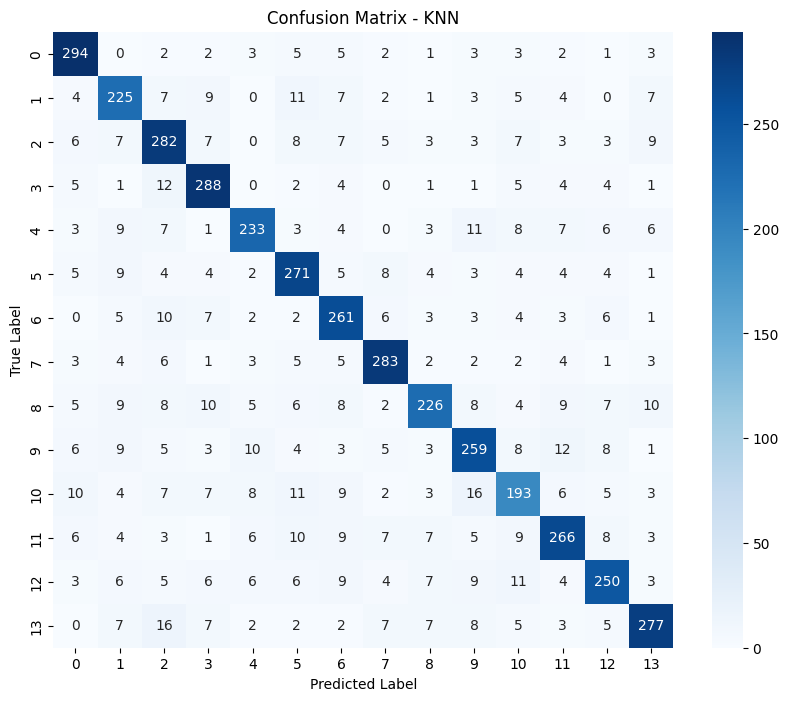

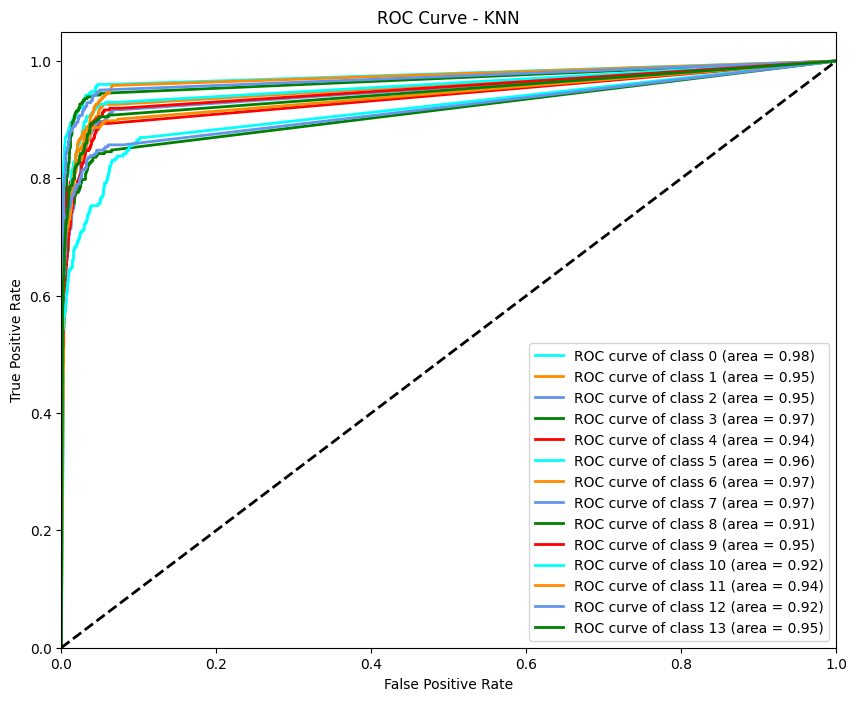


XGBoost Results:
Accuracy: 0.8148

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       326
           1       0.77      0.81      0.79       285
           2       0.78      0.77      0.78       350
           3       0.83      0.90      0.86       328
           4       0.83      0.79      0.81       301
           5       0.82      0.84      0.83       328
           6       0.76      0.83      0.79       313
           7       0.88      0.87      0.87       324
           8       0.86      0.79      0.82       317
           9       0.79      0.79      0.79       336
          10       0.72      0.72      0.72       284
          11       0.84      0.80      0.82       344
          12       0.83      0.76      0.79       329
          13       0.81      0.82      0.82       348

    accuracy                           0.81      4513
   macro avg       0.81      0.81      0.81      4513
weighted avg       0.

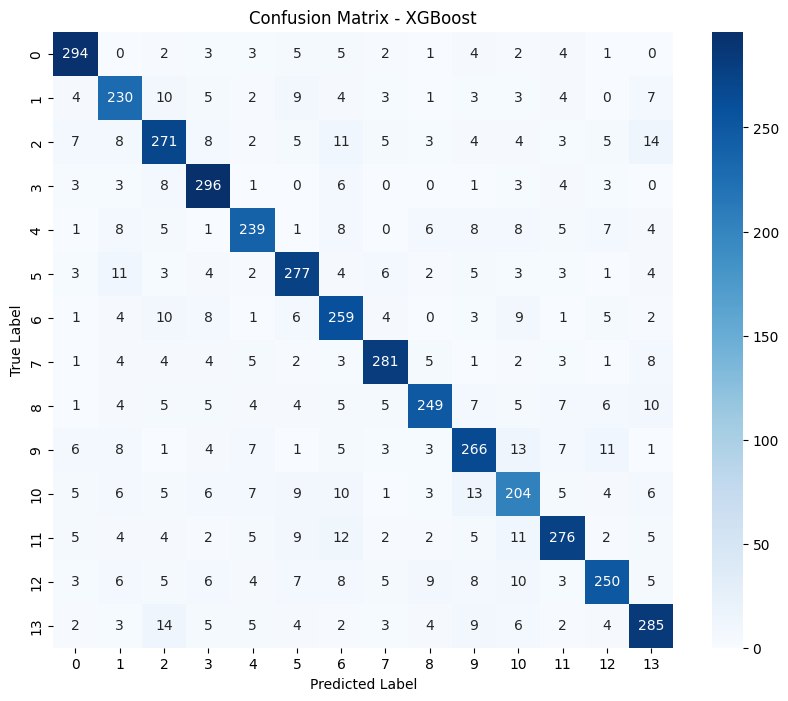

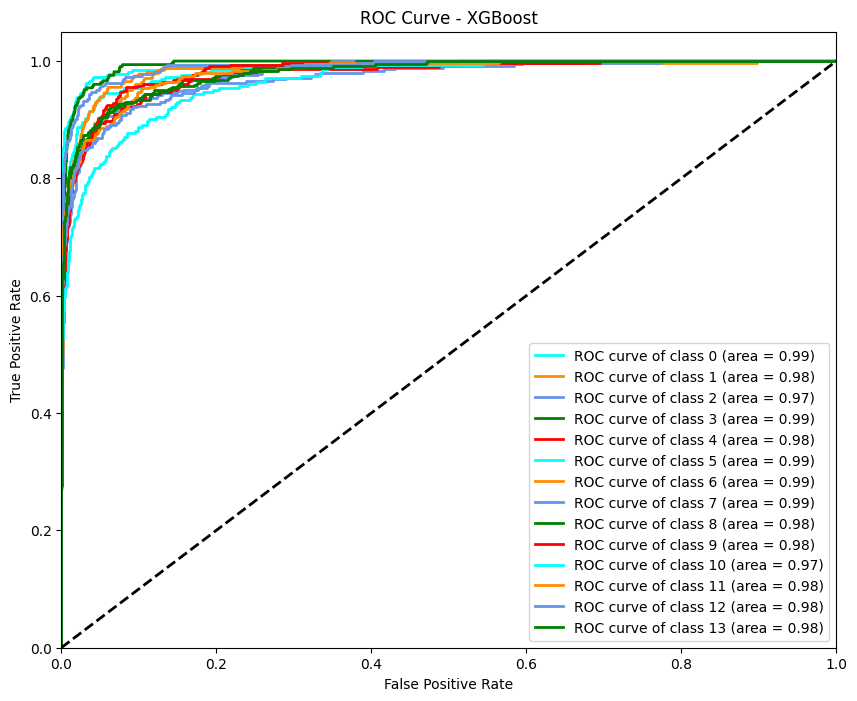

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model, Model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, RocCurveDisplay
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

def preprocess_features(data):
    # Separate features
    ul_flow_features = ['ul_total_num_pkts', 'ul_total_num_bytes', 'ul_min_pkt_size', 
                       'ul_max_pkt_size', 'ul_mean_pkt_size', 'ul_std_pkt_size']
    
    dl_flow_features = ['dl_total_num_pkts', 'dl_total_num_bytes', 'dl_min_pkt_size', 
                       'dl_max_pkt_size', 'dl_mean_pkt_size', 'dl_std_pkt_size']
    
    temporal_features = ['ul_min_iat', 'ul_max_iat', 'ul_mean_iat', 'ul_std_iat', 'ul_dur',
                        'dl_min_iat', 'dl_max_iat', 'dl_mean_iat', 'dl_std_iat', 'dl_dur']
    
    # Feature engineering
    data['ul_byte_pkt_ratio'] = data['ul_total_num_bytes'] / (data['ul_total_num_pkts'] + 1e-6)
    data['dl_byte_pkt_ratio'] = data['dl_total_num_bytes'] / (data['dl_total_num_pkts'] + 1e-6)
    data['total_duration'] = data['ul_dur'] + data['dl_dur']
    data['pkt_ratio'] = data['ul_total_num_pkts'] / (data['dl_total_num_pkts'] + 1e-6)
    
    # Log transform temporal features
    for col in temporal_features:
        data[col] = np.log1p(data[col])
    
    # IP address processing
    data['ip_A'] = data['ip_A'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    data['ip_B'] = data['ip_B'].astype(str).apply(lambda x: int(x.split('.')[-1]))
    
    # Protocol one-hot encoding
    protocol_encoder = OneHotEncoder(sparse_output=False)
    protocol_encoded = protocol_encoder.fit_transform(data[['protocal']])
    protocol_df = pd.DataFrame(protocol_encoded, 
                             columns=[f'protocol_{i}' for i in range(protocol_encoded.shape[1])])
    
    # Combine features
    feature_sets = {
        'ul_flow': ul_flow_features + ['ul_byte_pkt_ratio'],
        'dl_flow': dl_flow_features + ['dl_byte_pkt_ratio'],
        'temporal': temporal_features + ['total_duration'],
        'protocol': ['ip_A', 'ip_B', 'port_A', 'port_B'] + [f'protocol_{i}' for i in range(protocol_encoded.shape[1])]
    }
    
    # Scale features
    scalers = {}
    scaled_features = {}
    
    for name, feature_list in feature_sets.items():
        if name == 'protocol':
            features = pd.concat([data[['ip_A', 'ip_B', 'port_A', 'port_B']], protocol_df], axis=1)
        else:
            features = data[feature_list]
        
        scalers[name] = StandardScaler()
        scaled_features[name] = scalers[name].fit_transform(features)
    
    return scaled_features, scalers, protocol_encoder

def load_models_and_preprocess(data_path):
    # Load the saved models and preprocessors
    autoencoder = load_model('enhanced_autoencoder.h5')
    scalers = joblib.load('scalers.pkl')
    protocol_encoder = joblib.load('protocol_encoder.pkl')
    
    # Load and preprocess the data
    data = pd.read_csv(data_path)
    labels = data['app']
    
    # Preprocess features using the same function from the original code
    scaled_features, _, _ = preprocess_features(data)
    
    # Extract encoder part from autoencoder
    encoder = Model(
        inputs=autoencoder.inputs,
        outputs=autoencoder.get_layer('latent_space').output
    )
    
    # Get latent features
    latent_features = encoder.predict(list(scaled_features.values()))
    
    return latent_features, labels

def train_and_evaluate_models(X_train, X_test, y_train, y_test, model_name, model):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    classes = np.unique(y_train)
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]
    
    # Convert model to OneVsRest for ROC curve
    if model_name == "XGBoost":
        y_score = model.predict_proba(X_test)
    else:  # KNN
        y_score = model.predict_proba(X_test)
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    
    for i, (color, class_name) in enumerate(zip(colors, classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                label=f'ROC curve of class {class_name} (area = {roc_auc:0.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def main():
    # Load data and extract latent features
    latent_features, labels = load_models_and_preprocess('balanced_random_smoteenn.csv')
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        latent_features, labels, test_size=0.2, random_state=42
    )
    
    # Initialize models
    knn_model = KNeighborsClassifier(
        n_neighbors=5,
        weights='distance',
        metric='euclidean',
        n_jobs=-1
    )
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        objective='multi:softprob',
        random_state=42,
        n_jobs=-1
    )
    
    # Train and evaluate KNN
    train_and_evaluate_models(X_train, X_test, y_train, y_test, "KNN", knn_model)
    
    # Train and evaluate XGBoost
    train_and_evaluate_models(X_train, X_test, y_train, y_test, "XGBoost", xgb_model)
    
    # Save the models
    joblib.dump(knn_model, 'knn_classifier.pkl')
    joblib.dump(xgb_model, 'xgb_classifier.pkl')

if __name__ == "__main__":
    main()